In [1]:
import os
import time 
import random 
import tiny_utils # custom module
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import segmentation_models_pytorch as smp
from tiny_utils import ShipDatabaseSegmation
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_opening, disk, label

In [2]:
sample_imgs = tiny_utils.make_data("data/train_ship_segmentations_v2.csv")

In [3]:
print(sample_imgs.shape, "\n")
sample_imgs.head()

(10215, 2) 



,ImageId,EncodedPixels
215690,ee5fa437a.jpg,184647 1 185414 3 186181 5 186948 7 187715 8 1...
186289,cdc77a1bb.jpg,516427 77 517195 77 517963 77 518731 77 519499...
14957,106b591e6.jpg,204045 4 204811 6 205579 6 206347 6 207115 6 2...
231592,ffd5c101e.jpg,115008 1 115774 4 116540 6 117306 9 118072 11 ...
105332,740bc4ba5.jpg,4133 5 4901 9 5669 9 6436 10 7204 10 7977 5


In [4]:
tiny_utils.test()

'MODULE WORKS!!'

In [5]:
data = pd.read_csv("data/train_ship_segmentations_v2.csv")
data = data.dropna() 

In [6]:
data.shape

(81723, 2)

In [7]:
train, valid = train_test_split(data, test_size = 0.05, random_state=42)
print(train.shape[0], 'training set')
print(valid.shape[0], 'validation set')

77636 training set
4087 validation set


In [8]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor() 
])
ship_dataset_train = ShipDatabaseSegmation(train, "data/train_v2", transforms=transforms)
ship_dataset_valid = ShipDatabaseSegmation(valid, "data/train_v2", transforms=transforms)

train_loader = torch.utils.data.DataLoader(ship_dataset_train, batch_size=5, shuffle=True, num_workers=8)
valid_loader = torch.utils.data.DataLoader(ship_dataset_valid, batch_size=1, shuffle=False, num_workers=4)

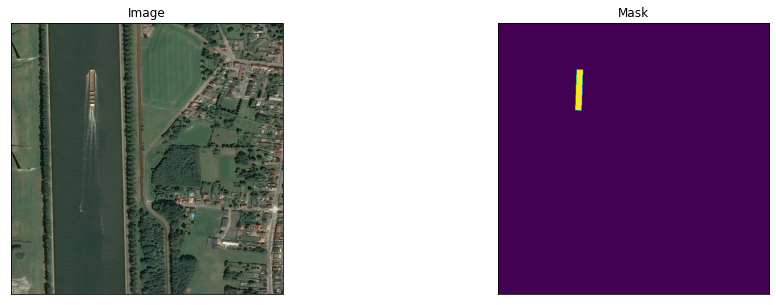

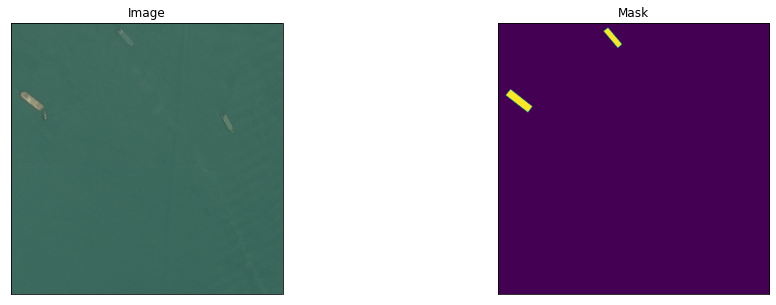

In [9]:
examples = iter(valid_loader)
for i in range(2):
    img, mask = next(examples)
    tiny_utils.visualize(image=img.squeeze().permute(1,2,0), mask = mask.squeeze(),)

In [10]:
# training 
loss = nn.BCEWithLogitsLoss()
loss.__name__ = "bceWithLogitLoss"
device = "cuda"
metrics = [smp.utils.metrics.IoU(threshold=0.5),]

In [11]:
def train(model, epochs, model_name, device='cuda', lr=0.0001):
    optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=lr),])

    # create epoch runners 
    # it is a simple loop of iterating over dataloader`s samples
    train_epoch = smp.utils.train.TrainEpoch(model, 
                                             loss=loss, 
                                             metrics=metrics, 
                                             optimizer=optimizer,
                                             device=device,
                                             verbose=True,)

    valid_epoch = smp.utils.train.ValidEpoch(model, 
                                             loss=loss, 
                                             metrics=metrics, 
                                             device=device,
                                             verbose=True,)
    print("start train model : ", model_name)
    
    max_score = 0
    for i in range(0, epochs):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './'+model_name+'_best_model.pth')
            print('Model saved!')

        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')
        if i % 5 == 0:
            torch.save(model, './'+model_name+'_epoch_'+str(i)+'_'+str(time.time())+'.pth')
            print("save model !")

In [12]:
encoder = 'resnet50'
encoder_weights ='imagenet'
num_epochs = 20
device = 'cuda'
lr = 0.0001
# Unet = smp.Unet(encoder,encoder_weights=encoder_weights)
FPN = smp.FPN(encoder,encoder_weights=encoder_weights) 

In [13]:
torch.cuda.empty_cache()

In [14]:
# train(model=FPN, epochs=num_epochs, model_name="FPN", device=device, lr=lr) 

![MODEL EPOCH SNIPPET REF](model_snippet.png)

In [15]:
FPN = torch.load("FPN_best_model.pth") 

In [16]:
test_epoch_FPN = smp.utils.train.ValidEpoch(FPN, 
                                            loss=loss, 
                                            metrics=metrics, 
                                            device=device,
                                            verbose=True,)

In [17]:
valid_logs = test_epoch_FPN.run(valid_loader) #  on data validation
train_logs = test_epoch_FPN.run(train_loader) #  on data train

valid: 100%|███████████████████████████████████████████████████████████| 8228/8228 [35:33<00:00,  3.86it/s, bceWithLogitLoss - 0.004049, iou_score - 0.6713]


In [18]:
train_logs

{'bceWithLogitLoss': 0.004049321832868845, 'iou_score': 0.6713313202088649}

In [19]:
# validation 
validation_set = pd.read_csv("data/sample_submission_v2.csv") 
validation_set["ImageId"][:5] 

0    00002bd58.jpg
1    00015efb6.jpg
2    00023d5fc.jpg
3    000367c13.jpg
4    0008ca6e9.jpg
Name: ImageId, dtype: object

In [20]:
tiny_utils.validation_pred("data/test_v2/", validation_set["ImageId"][6:15], FPN, 'cuda')

[{'ImageId': '000bd9dbf.jpg', 'EncodedPixels': None},
 {'ImageId': '000f7d875.jpg', 'EncodedPixels': None},
 {'ImageId': '0010551d9.jpg',
  'EncodedPixels': '183034 12 183798 21 184565 24 185331 29 186098 31 186865 35 187632 38 188399 43 189166 45 189934 46 190702 48 191469 50 192237 52 193005 54 193772 57 194540 62 195308 64 196076 65 196844 67 197611 70 198380 71 199148 73 199916 76 200684 80 201452 81 202220 82 202988 84 203756 86 204525 87 205293 88 206062 90 206830 93 207599 93 208368 94 209137 95 209906 97 210675 99 211444 101 212213 103 212983 104 213752 104 214522 104 215291 104 216060 106 216831 106 217602 106 218372 106 219142 107 219913 105 220683 105 221452 107 222222 109 222992 110 223763 112 224533 113 225303 116 226074 115 226843 115 227612 115 228381 115 229151 114 229921 113 230691 113 231461 112 232231 110 233002 108 233773 106 234542 106 235313 104 236084 102 236854 101 237627 97 238396 96 239164 97 239933 96 240702 95 241472 94 242242 92 243012 91 243783 88 244555 8

In [21]:
validation_set.iloc[6:15]

,ImageId,EncodedPixels
6,000bd9dbf.jpg,1 2
7,000f7d875.jpg,1 2
8,0010551d9.jpg,1 2
9,001839c6f.jpg,1 2
10,002a943bf.jpg,1 2
11,00313b166.jpg,1 2
12,00327b02d.jpg,1 2
13,0035268d9.jpg,1 2
14,003b58a76.jpg,1 2


In [22]:
# sample of prediction on a single image [FPN Model]
test_img = tiny_utils.validation_pred("data/test_v2/",validation_set[validation_set["ImageId"] == "0b7359c38.jpg"].ImageId, FPN, 'cuda')

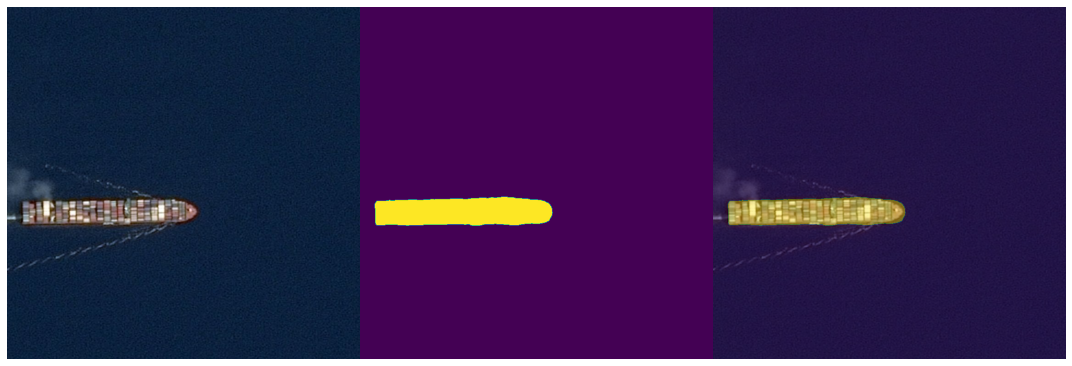

In [23]:
from skimage import io 

ImageId = '0b7359c38.jpg'

img = io.imread("./data/test_v2/"+ImageId)
img_masks = [test_img[0]['EncodedPixels']]

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += tiny_utils.rle_decode(mask, (768, 768))
    

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [32]:
# sample pred 2 
test_img = tiny_utils.validation_pred("data/test_v2/",validation_set[validation_set["ImageId"] == "1b5fd69bc.jpg"].ImageId, FPN, 'cuda')


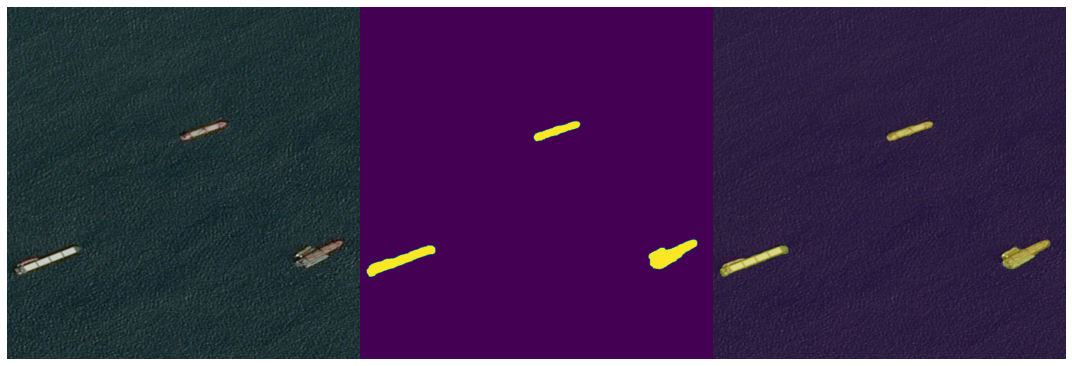

In [46]:
ImageId = '1b5fd69bc.jpg'

img = io.imread("./data/test_v2/"+ImageId)
all_masks = np.zeros((768, 768))
for i in test_img: 
    for mask in [i['EncodedPixels']]:
        all_masks += tiny_utils.rle_decode(mask, (768, 768))    

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()